In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [38]:
from sqlalchemy.sql import label

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# Engine connection for queries
connection = engine.connect()

In [7]:
# reflect an existing database into a new model

# Declare a Base using `automap_base()`
Base = automap_base()

# reflect the tables via use of Base class 
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
measurement =  Base.classes.measurement
station = Base.classes.station

In [10]:
# Identify columns in each table
inspector = inspect(engine)

print("Measurement Table Columns")
m_columns = inspector.get_columns('measurement')
for column in m_columns:
    print(column["name"], column["type"])

print ('\nStation Table Columns')
s_columns = inspector.get_columns('station')
for column in s_columns:
    print(column["name"], column["type"])

Measurement Table Columns
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT

Station Table Columns
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [148]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Identify the max date in the database
last_date = session.query(func.max(measurement.date)).all()[0][0]
#print(f'The max date in the dataset is: {last_date}, its type is {type(max_date)} \n')

# Convert date to datetime format
dt_max_date = dt.datetime.strptime(last_date, '%Y-%m-%d')

# Calculate the date 1 year prior to last date in database
date_year_prior = dt_max_date - dt.timedelta(days=365)
#print(f'365 days prior to last date in dataset: {year_prior.date()} \n')

# Perform a query to retrieve the data and precipitation scores
results = (session.query(measurement.date, measurement.prcp).
           filter(measurement.date>=date_year_prior).all())

# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df = pd.DataFrame(results, columns=['Date','Precipitation'])
c_precipitation_df = precipitation_df.dropna()

# Format Date column to date time
c_precipitation_df['Date'] = pd.to_datetime(c_precipitation_df['Date'], yearfirst=True)

# Sort the dataframe by date
sorted_precip = c_precipitation_df.sort_values(by=['Date'])
sorted_precip

C:\Users\szerp\Anacoda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Date,Precipitation
0,2016-08-24,0.08
1188,2016-08-24,1.22
702,2016-08-24,2.28
1875,2016-08-24,1.45
360,2016-08-24,2.15
...,...,...
2221,2017-08-22,0.50
359,2017-08-23,0.00
1523,2017-08-23,0.08
1005,2017-08-23,0.00


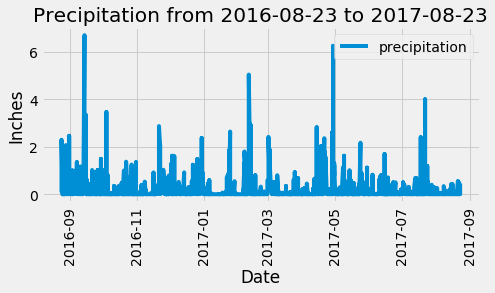

In [14]:
# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(7,3))
plt.plot(sorted_precip['Date'], sorted_precip['Precipitation'])
plt.title(f'Precipitation from {date_year_prior.date()} to {last_date}')
plt.xlabel('Date')
plt.xticks(rotation=90)
plt.ylabel('Inches')
plt.legend(['precipitation'], loc='upper right')
plt.show()

In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data

summary_df = sorted_precip[['Precipitation']].agg(['mean', 'median', 'var', 'std', 'sem'])
summary_df

,Precipitation
mean,0.176462
median,0.020000
var,0.211865
std,0.460288
sem,0.010254


In [25]:
# Design a query to show how many stations are available in this dataset
station_results = session.query(func.count(station.station)).all()
station_results

[(9)]

In [138]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

station_freq = (session.query(station.station, func.count(measurement.station).label('station_count')).
                filter(station.station == measurement.station).
                group_by(station.name).
                order_by((station_count).desc()).
                all())
station_freq

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [139]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

max_count_station = station_freq[0][0]

station_temp = (session.query(measurement.station, 
                                func.min(measurement.tobs).label('min_temp'), 
                                func.max(measurement.tobs).label('max_temp'), 
                                func.avg(measurement.tobs).label('average_temp')).
                    filter(station.station == max_count_station ).
                    all())
station_temp


[('USC00519397', 53.0, 87.0, 73.09795396419437)]

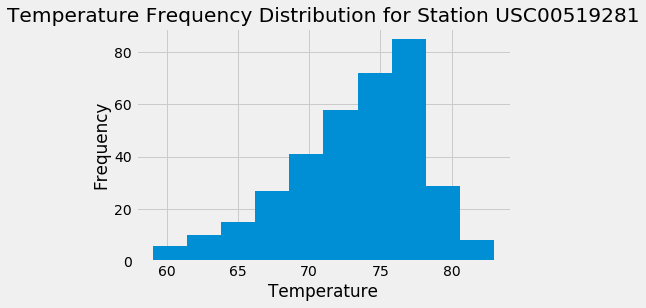

In [143]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

station_year_temp = (session.query(measurement.tobs).
                    filter(measurement.date >= date_year_prior).
                    filter(measurement.station == max_count_station).
                    all())

station_year_temp_df = pd.DataFrame(station_year_temp, columns=['tobs'])
station_year_temp_df = station_year_temp_df.dropna()

# Result Plot
plt.hist(station_year_temp_df['tobs'])
plt.title(f'Temperature Frequency Distribution for Station {max_count_station }')
plt.ylabel('Frequency')
plt.xlabel('Temperature')
plt.show()

## Bonus Challenge Assignment

In [146]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [184]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
years_t_data = calc_temps(date_year_prior, last_date)

tavg = years_t_data[0][1]
tmin = years_t_data[0][0]
tmax = years_t_data[0][2]

years_t_data

[(58.0, 74.57894736842105, 87.0)]

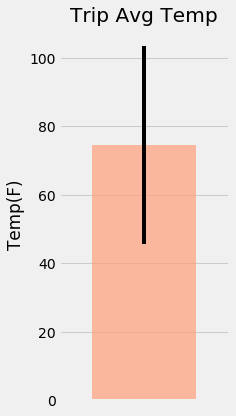

In [389]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

t_avg_df = pd.DataFrame({'Temperature Average': [tavg]})
tick_loc = [1]

t_avg_df.plot(kind='bar', width=.8, yerr=[tmax-tmin], color='lightsalmon', 
              legend=False, figsize=(3.5,6), alpha=.7)
plt.title('Trip Avg Temp')
plt.ylabel('Temp(F)')
plt.xticks(tick_loc)
plt.tight_layout()
plt.show()

In [408]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

rainfall_by_station = (session.query(station.name, func.sum(measurement.prcp).label('total_rainfall')).
                        filter(station.station == measurement.station).
                        filter(measurement.date >= date_year_prior).
                        group_by(measurement.station).
                        order_by(func.sum(measurement.prcp).desc()).
                        all())

rainfall_by_station

[('MANOA LYON ARBO 785.2, HI US', 147.11000000000004),
 ('WAIHEE 837.5, HI US', 68.24000000000002),
 ('KANEOHE 838.1, HI US', 48.36000000000003),
 ('WAIMANALO EXPERIMENTAL FARM, HI US', 37.99),
 ('KUALOA RANCH HEADQUARTERS 886.9, HI US', 33.19),
 ('WAIKIKI 717.2, HI US', 16.089999999999986),
 ('PEARL CITY, HI US', 4.59)]

In [411]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [417]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


'08-2016'

In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
